In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fertility-data-set/fertility.csv


🔍 FERTILITY ANALYSIS PIPELINE 🔍

📊 LOADING DATA...
✅ Data loaded successfully: 100 rows, 10 columns

🧹 CLEANING DATA...
Columns: ['Season', 'Age', 'Childish diseases', 'Accident or serious trauma', 'Surgical intervention', 'High fevers in the last year', 'Frequency of alcohol consumption', 'Smoking habit', 'Number of hours spent sitting per day', 'Diagnosis']

Data sample:
   Season  Age Childish diseases Accident or serious trauma  \
0  spring   30                no                        yes   
1  spring   35               yes                         no   
2  spring   27               yes                         no   
3  spring   32                no                        yes   
4  spring   30               yes                        yes   

  Surgical intervention High fevers in the last year  \
0                   yes       more than 3 months ago   
1                   yes       more than 3 months ago   
2                    no       more than 3 months ago   
3                   y

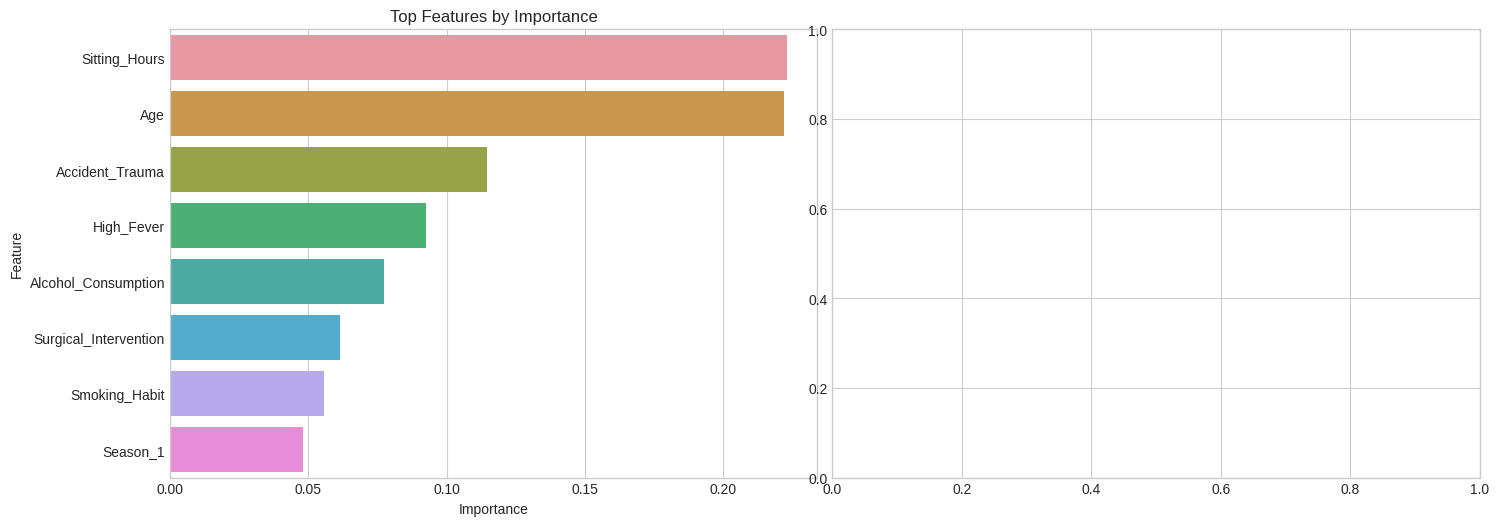

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.utils import resample
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

print("🔍 FERTILITY ANALYSIS PIPELINE 🔍")
print("=" * 50)

# STEP 1: Load the data
print("\n📊 LOADING DATA...")
try:
    df = pd.read_csv('/kaggle/input/fertility-data-set/fertility.csv')
    print(f"✅ Data loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns")
except Exception as e:
    print(f"❌ Error loading data: {e}")
    # If the path is wrong, provide a fallback
    try:
        df = pd.read_csv('fertility.csv')
        print(f"✅ Data loaded from alternate path: {df.shape[0]} rows, {df.shape[1]} columns")
    except:
        print("❌ Could not load data from alternate path either")
        raise

# STEP 2: Clean column names and inspect data
print("\n🧹 CLEANING DATA...")
df.columns = df.columns.str.strip()
print("Columns:", df.columns.tolist())

# Display the first few rows to see the data format
print("\nData sample:")
print(df.head())

print("\nData types:")
print(df.dtypes)

# STEP 3: Manual column mapping based on the actual dataset
column_mapping = {
    'Season': 'Season',                                      # -1,0,1,2 --> winter, spring, summer, fall
    'Age': 'Age',                                            # 18-36 (numerical)
    'Childish diseases': 'Child_Disease',                    # yes/no
    'Accident or serious trauma': 'Accident_Trauma',         # yes/no
    'Surgical intervention': 'Surgical_Intervention',        # yes/no
    'High fevers in the last year': 'High_Fever',            # less than 3 months ago, more than 3 months ago, no
    'Frequency of alcohol consumption': 'Alcohol_Consumption', # several times a day, every day, several times a week, once a week, hardly ever or never
    'Smoking habit': 'Smoking_Habit',                        # never, occasional, daily
    'Number of hours spent sitting per day': 'Sitting_Hours', # 0-16 (numerical)
    'Diagnosis': 'Output'                                    # N=normal, O=altered
}

# Attempt to map columns based on the expected format
try:
    # First check if original column names are in the dataframe
    original_columns = list(column_mapping.keys())
    rename_dict = {}
    
    for i, col in enumerate(df.columns):
        if i < len(original_columns):
            rename_dict[col] = column_mapping[original_columns[i]]
    
    # If no matches, use positional renaming
    if not rename_dict:
        new_columns = list(column_mapping.values())
        rename_dict = {old: new for old, new in zip(df.columns, new_columns)}
    
    df = df.rename(columns=rename_dict)
    print("Renamed columns:", df.columns.tolist())
except Exception as e:
    print(f"Error during column renaming: {e}")
    # Fallback to direct column renaming by position
    expected_columns = ['Season', 'Age', 'Child_Disease', 'Accident_Trauma', 'Surgical_Intervention',
                       'High_Fever', 'Alcohol_Consumption', 'Smoking_Habit', 'Sitting_Hours', 'Output']
    
    if len(df.columns) == len(expected_columns):
        df.columns = expected_columns
        print("Applied fallback column names:", df.columns.tolist())

# STEP 4: Exploratory data analysis
print("\n📈 EXPLORING DATA...")
print("\nData summary statistics:")
print(df.describe(include='all'))

print("\nUnique values per column:")
for col in df.columns:
    unique_vals = df[col].unique()
    print(f"{col}: {unique_vals}")

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Check for duplicates
print(f"\nDuplicate rows: {df.duplicated().sum()}")

# STEP 5: Transform features to numeric values
print("\n🔄 TRANSFORMING FEATURES...")

# Store original data for visualization
df_original = df.copy()

# Season mapping (winter=-1, spring=0, summer=1, fall=2 OR winter=0, spring=1, summer=2, fall=3)
try:
    # First check data type
    if df['Season'].dtype == 'object':
        # Handle text seasons
        season_map = {
            'winter': 0, 'spring': 1, 'summer': 2, 'fall': 3, 
            'Winter': 0, 'Spring': 1, 'Summer': 2, 'Fall': 3
        }
    else:
        # Handle numeric seasons (based on the known encoding)
        unique_seasons = sorted(df['Season'].unique())
        if len(unique_seasons) == 4:
            if min(unique_seasons) < 0:
                # Likely -1,0,1,2 encoding
                season_map = {-1: 0, 0: 1, 1: 2, 2: 3}
            else:
                # Likely 0,1,2,3 encoding
                season_map = {i: i for i in unique_seasons}
    
    # Apply mapping
    df['Season'] = df['Season'].map(season_map)
    print("✓ Season values mapped")
except Exception as e:
    print(f"⚠️ Error mapping Season: {e}")
    # If mapping fails, attempt conversion to numeric
    try:
        df['Season'] = pd.to_numeric(df['Season'])
        print("✓ Season converted to numeric directly")
    except:
        print("⚠️ Could not convert Season to numeric")

# Binary features (yes/no, Y/N)
binary_columns = ['Child_Disease', 'Accident_Trauma', 'Surgical_Intervention']
for col in binary_columns:
    try:
        # Check the type of values
        unique_vals = df[col].unique()
        
        # Convert text values
        if df[col].dtype == 'object':
            yes_values = ['yes', 'Yes', 'YES', 'y', 'Y', 'True', 'true', '1']
            no_values = ['no', 'No', 'NO', 'n', 'N', 'False', 'false', '0']
            
            # Create mapping dictionary
            value_map = {}
            for val in unique_vals:
                if val in yes_values:
                    value_map[val] = 1
                elif val in no_values:
                    value_map[val] = 0
            
            # Apply mapping if we have matches
            if value_map:
                df[col] = df[col].map(value_map)
                print(f"✓ {col} values mapped")
            else:
                # Try another approach with manual mapping
                if len(unique_vals) == 2:
                    # Assume less frequent is "yes" (usually the case)
                    counts = df[col].value_counts()
                    yes_val = counts.index[counts.argmin()]
                    no_val = counts.index[counts.argmax()]
                    df[col] = df[col].map({no_val: 0, yes_val: 1})
                    print(f"✓ {col} values mapped by frequency")
        
        # Convert to numeric as final fallback
        df[col] = pd.to_numeric(df[col], errors='coerce')
        print(f"✓ {col} converted to numeric")
    except Exception as e:
        print(f"⚠️ Error processing {col}: {e}")

# High fever (three-value feature: less than 3 months ago, more than 3 months ago, no)
try:
    unique_fevers = df['High_Fever'].unique()
    
    # Map based on string values or specific categories
    if df['High_Fever'].dtype == 'object':
        fever_map = {
            'less than 3 months ago': 2,
            'more than 3 months ago': 1,
            'no': 0,
            'No': 0,
            'NO': 0,
            'Yes, less than 3 months ago': 2,
            'Yes, more than 3 months ago': 1
        }
        
        # Apply mapping
        df['High_Fever'] = df['High_Fever'].map(fever_map)
        print("✓ High_Fever values mapped")
    else:
        # Try to convert to numeric directly
        df['High_Fever'] = pd.to_numeric(df['High_Fever'], errors='coerce')
        print("✓ High_Fever converted to numeric directly")
except Exception as e:
    print(f"⚠️ Error mapping High_Fever: {e}")

# Alcohol consumption (ordinal feature)
try:
    unique_alcohol = df['Alcohol_Consumption'].unique()
    
    # Map based on string values
    if df['Alcohol_Consumption'].dtype == 'object':
        alcohol_map = {
            'several times a day': 4,
            'every day': 3,
            'several times a week': 2,
            'once a week': 1,
            'hardly ever or never': 0,
            'never': 0
        }
        
        # Apply mapping
        df['Alcohol_Consumption'] = df['Alcohol_Consumption'].map(alcohol_map)
        print("✓ Alcohol_Consumption values mapped")
    else:
        # Try to convert to numeric directly
        df['Alcohol_Consumption'] = pd.to_numeric(df['Alcohol_Consumption'], errors='coerce')
        print("✓ Alcohol_Consumption converted to numeric directly")
except Exception as e:
    print(f"⚠️ Error mapping Alcohol_Consumption: {e}")

# Smoking habit (ordinal feature: never, occasional, daily)
try:
    unique_smoking = df['Smoking_Habit'].unique()
    
    # Map based on string values
    if df['Smoking_Habit'].dtype == 'object':
        smoking_map = {
            'never': 0,
            'occasional': 1,
            'daily': 2
        }
        
        # Apply mapping
        df['Smoking_Habit'] = df['Smoking_Habit'].map(smoking_map)
        print("✓ Smoking_Habit values mapped")
    else:
        # Try to convert to numeric directly
        df['Smoking_Habit'] = pd.to_numeric(df['Smoking_Habit'], errors='coerce')
        print("✓ Smoking_Habit converted to numeric directly")
except Exception as e:
    print(f"⚠️ Error mapping Smoking_Habit: {e}")

# Output/target (N=normal, O=altered)
try:
    unique_output = df['Output'].unique()
    
    # Map based on string values
    if df['Output'].dtype == 'object':
        output_map = {
            'N': 1,  # Normal
            'O': 0,  # Altered
            'Normal': 1,
            'Altered': 0,
            'normal': 1,
            'altered': 0
        }
        
        # Apply mapping
        df['Output'] = df['Output'].map(output_map)
        print("✓ Output values mapped")
    else:
        # If already numeric, keep as is
        pass
except Exception as e:
    print(f"⚠️ Error mapping Output: {e}")

# Convert any remaining string columns to numeric
for col in df.columns:
    if df[col].dtype == 'object':
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            print(f"✓ {col} converted to numeric")
        except Exception as e:
            print(f"⚠️ Cannot convert {col} to numeric: {e}")

# Handle any remaining NaN values
print("\nHandling missing values after transformation:")
for col in df.columns:
    if df[col].isnull().sum() > 0:
        print(f"Column {col} has {df[col].isnull().sum()} NaN values")
        if col == 'Output':
            # Drop rows with missing targets
            df = df.dropna(subset=['Output'])
            print(f"  Dropped rows with missing target values")
        else:
            # Fill missing values
            if df[col].dtype in [np.float64, np.int64]:
                df[col] = df[col].fillna(df[col].median())
                print(f"  Filled with median")
            else:
                df[col] = df[col].fillna(df[col].mode()[0])
                print(f"  Filled with mode")

# Check data after transformation
print("\nData after transformation:")
print(df.head())
print("\nData types after transformation:")
print(df.dtypes)

# STEP 6: One-hot encode Season (if it's categorical)
try:
    if df['Season'].nunique() > 2:
        # Create dummy variables for Season
        season_dummies = pd.get_dummies(df['Season'], prefix='Season')
        # Drop the original Season column and join with dummies
        df = df.drop('Season', axis=1).join(season_dummies)
        print("✓ Season one-hot encoded")
except Exception as e:
    print(f"⚠️ Error one-hot encoding Season: {e}")

# STEP 7: Scale numerical features
print("\n⚖️ SCALING NUMERICAL FEATURES...")
# Age and Sitting_Hours should be scaled
numerical_features = ['Age', 'Sitting_Hours']
scaler = StandardScaler()

try:
    df[numerical_features] = scaler.fit_transform(df[numerical_features])
    print(f"✓ Scaled numerical features: {numerical_features}")
except Exception as e:
    print(f"⚠️ Error scaling numerical features: {e}")
    # Try to handle individually
    for col in numerical_features:
        try:
            df[col] = (df[col] - df[col].mean()) / df[col].std()
            print(f"✓ Manually scaled {col}")
        except Exception as e:
            print(f"⚠️ Could not scale {col}: {e}")

# STEP 8: Prepare features and target
print("\n🎯 PREPARING FEATURES AND TARGET...")
X = df.drop('Output', axis=1)
y = df['Output']
print(f"Features shape: {X.shape}, Target shape: {y.shape}")

# STEP 9: Train-test split with stratification
print("\n✂️ PERFORMING TRAIN-TEST SPLIT...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

# STEP 10: Handle class imbalance
print("\n⚖️ HANDLING CLASS IMBALANCE...")
print(f"Before balancing - Class distribution: {pd.Series(y_train).value_counts().to_dict()}")

# Manual upsampling using sklearn's resample
try:
    # Combine features and target for resampling
    train_data = pd.concat([X_train, y_train], axis=1)
    
    # Identify majority and minority classes
    class_counts = y_train.value_counts()
    majority_class = class_counts.idxmax()
    minority_class = class_counts.idxmin()
    
    # Separate majority and minority classes
    majority = train_data[train_data.Output == majority_class]
    minority = train_data[train_data.Output == minority_class]
    
    # Check if minority exists
    if len(minority) > 0:
        # Upsample minority class to match majority class size
        minority_upsampled = resample(
            minority, 
            replace=True,              # Sample with replacement
            n_samples=len(majority),   # Match majority class size
            random_state=42            # For reproducibility
        )
        
        # Combine majority class with upsampled minority class
        train_balanced = pd.concat([majority, minority_upsampled])
        
        # Extract features and target from balanced dataset
        X_train_balanced = train_balanced.drop('Output', axis=1)
        y_train_balanced = train_balanced['Output']
        
        print(f"After upsampling - Class distribution: {pd.Series(y_train_balanced).value_counts().to_dict()}")
    else:
        print("⚠️ No minority class samples found, skipping upsampling")
        X_train_balanced, y_train_balanced = X_train, y_train
except Exception as e:
    print(f"⚠️ Manual upsampling failed: {e}. Using original data...")
    X_train_balanced, y_train_balanced = X_train, y_train

# STEP 11: Feature importance analysis
print("\n🔍 ANALYZING FEATURE IMPORTANCE...")
try:
    # Quick Random Forest for feature importance
    feature_analyzer = RandomForestClassifier(n_estimators=100, random_state=42)
    feature_analyzer.fit(X_train_balanced, y_train_balanced)
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_analyzer.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("Top features by importance:")
    print(feature_importance.head(5))
except Exception as e:
    print(f"⚠️ Feature importance analysis failed: {e}")
    # Create empty DataFrame
    feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.zeros(X.shape[1])})

# STEP 12: Train and evaluate models
print("\n🔨 TRAINING AND EVALUATING MODELS...")

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Helper function to train, evaluate and report metrics for a model"""
    print(f"\n📊 Evaluating: {model_name}")
    
    try:
        # Train the model
        model.fit(X_train, y_train)
        
        # Cross-validation score
        try:
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
            print(f"Cross-validation F1 score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
        except Exception as e:
            print(f"⚠️ Cross-validation failed: {e}")
        
        # Predictions on test set
        y_pred = model.predict(X_test)
        
        # Evaluation metrics
        print("Confusion Matrix:")
        cm = confusion_matrix(y_test, y_pred)
        print(cm)
        
        print("\nClassification Report:")
        report = classification_report(y_test, y_pred)
        print(report)
        
        # Calculate ROC and AUC if model supports predict_proba
        try:
            y_prob = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = auc(fpr, tpr)
            print(f"ROC AUC: {roc_auc:.4f}")
            
            # Save ROC curve data for plotting
            roc_data = {
                'model': model_name,
                'fpr': fpr,
                'tpr': tpr,
                'auc': roc_auc
            }
        except Exception as e:
            print(f"⚠️ ROC calculation failed: {e}")
            roc_data = None
        
        return {
            'model': model,
            'name': model_name,
            'accuracy': (y_pred == y_test).mean(),
            'report': report,
            'confusion_matrix': cm,
            'roc_data': roc_data
        }
    except Exception as e:
        print(f"⚠️ Model evaluation failed: {e}")
        return {
            'model': model,
            'name': model_name,
            'accuracy': 0,
            'report': "Failed",
            'confusion_matrix': None,
            'roc_data': None
        }

# Define models with hyperparameters
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C=1.0, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(
        n_estimators=100, 
        max_depth=5,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=42
    ),
    "SVM": SVC(
        C=1.0, 
        kernel='rbf', 
        gamma='scale', 
        probability=True,
        class_weight='balanced',
        random_state=42
    )
}

# Train and evaluate models
results = {}
best_model = None
best_f1 = 0

for name, model in models.items():
    result = evaluate_model(model, X_train_balanced, y_train_balanced, X_test, y_test, name)
    results[name] = result
    
    # Extract F1 score from the classification report if available
    if result['report'] != "Failed":
        report_lines = result['report'].split('\n')
        for line in report_lines:
            if line.strip().startswith('weighted avg'):
                metrics = line.split()
                if len(metrics) >= 5:
                    f1_score = float(metrics[3])
                    if f1_score > best_f1:
                        best_f1 = f1_score
                        best_model = name

if best_model:
    print(f"\n🏆 Best model: {best_model} with weighted F1-score: {best_f1:.4f}")
else:
    print("\n⚠️ No best model could be determined")
    # Set default
    best_model = "Random Forest"

# STEP 13: Create visualizations
print("\n📊 CREATING VISUALIZATIONS...")

try:
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Feature Importance
    plt.subplot(2, 2, 1)
    top_features = feature_importance.head(min(8, len(feature_importance)))
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title('Top Features by Importance')
    plt.tight_layout()
    
    # Plot 2: Target Distribution
    plt.subplot(2, 2, 2)
    target_counts = pd.DataFrame({'Output': df_original['Output'].map({'N': 'Normal', 'O': 'Altered'})})
    sns.countplot(x='Output', data=target_counts)
    plt.title('Fertility Class Distribution')
    plt.xlabel('Fertility Status')
    plt.tight_layout()
    
    # Plot 3: ROC Curves
    plt.subplot(2, 2, 3)
    plt.plot([0, 1], [0, 1], 'k--')
    for name, result in results.items():
        if result['roc_data']:
            plt.plot(
                result['roc_data']['fpr'],
                result['roc_data']['tpr'],
                label=f"{name} (AUC = {result['roc_data']['auc']:.2f})"
            )
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='best')
    plt.tight_layout()
    
    # Plot 4: Correlation Matrix for numerical features
    plt.subplot(2, 2, 4)
    numeric_df = df.select_dtypes(include=['float64', 'int64']).copy()
    if 'Output' in numeric_df.columns:
        corr = numeric_df.corr()
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        plt.title('Feature Correlation Matrix')
    else:
        plt.text(0.5, 0.5, 'No numeric correlation data available', 
                horizontalalignment='center', verticalalignment='center')
    plt.tight_layout()
    
    plt.savefig('fertility_analysis_plots.png')
    plt.show()
    
    # Additional plots
    plt.figure(figsize=(15, 5))
    
    # Plot A: Age vs Fertility
    plt.subplot(1, 3, 1)
    age_df = df_original.copy()
    age_df['Output_Numeric'] = df['Output']
    sns.boxplot(x='Output', y='Age', data=age_df)
    plt.title('Age vs Fertility Status')
    plt.xlabel('Fertility Status')
    
    # Plot B: Smoking vs Fertility
    plt.subplot(1, 3, 2)
    smoking_df = df_original.copy()
    smoking_df['Output_Numeric'] = df['Output']
    if smoking_df['Smoking_Habit'].dtype == 'object':
        avg_by_smoking = smoking_df.groupby('Smoking_Habit')['Output_Numeric'].mean().reset_index()
        sns.barplot(x='Smoking_Habit', y='Output_Numeric', data=avg_by_smoking)
    else:
        sns.barplot(x='Smoking_Habit', y='Output_Numeric', data=smoking_df)
    plt.title('Smoking Habit vs Fertility')
    plt.xlabel('Smoking Habit')
    plt.ylabel('Proportion with Normal Fertility')
    
    # Plot C: Alcohol vs Fertility
    plt.subplot(1, 3, 3)
    alcohol_df = df_original.copy()
    alcohol_df['Output_Numeric'] = df['Output']
    if alcohol_df['Alcohol_Consumption'].dtype == 'object':
        avg_by_alcohol = alcohol_df.groupby('Alcohol_Consumption')['Output_Numeric'].mean().reset_index()
        sns.barplot(x='Alcohol_Consumption', y='Output_Numeric', data=avg_by_alcohol)
    else:
        sns.barplot(x='Alcohol_Consumption', y='Output_Numeric', data=alcohol_df)
    plt.title('Alcohol Consumption vs Fertility')
    plt.xlabel('Alcohol Consumption')
    plt.ylabel('Proportion with Normal Fertility')
    
    plt.tight_layout()
    plt.savefig('fertility_factors_plots.png')
    plt.show()
except Exception as e:
    print(f"⚠️ Error creating visualizations: {e}")

# STEP 14: Save outputs
print("\n💾 SAVING OUTPUTS...")

try:
    # Save cleaned data
    df.to_csv('/kaggle/working/fertility_cleaned.csv', index=False)
    
    # Save best model if available
    if best_model and results[best_model]['model'] is not None:
        best_model_obj = results[best_model]['model']
        joblib.dump(best_model_obj, '/kaggle/working/fertility_model.pkl')
    
    # Save feature importance
    feature_importance.to_csv('/kaggle/working/feature_importance.csv', index=False)
    
    print("✅ Saved cleaned data, feature importance, and model")
except Exception as e:
    print(f"⚠️ Error saving outputs to Kaggle: {e}")
    # Try alternate paths
    try:
        df.to_csv('fertility_cleaned.csv', index=False)
        if best_model and results[best_model]['model'] is not None:
            joblib.dump(results[best_model]['model'], 'fertility_model.pkl')
        feature_importance.to_csv('feature_importance.csv', index=False)
        print("✅ Saved to current directory instead")
    except Exception as e:
        print(f"❌ Could not save outputs: {e}")

# STEP 15: Final summary
print("\n📝 SUMMARY OF FINDINGS...")

if best_model and results[best_model]['model'] is not None:
    print(f"Best model: {best_model}")
    
    # Report top features if available
    if not feature_importance.empty:
        print("\nTop factors affecting fertility:")
        for i, (feature, importance) in enumerate(zip(feature_importance['Feature'].head(3), 
                                                feature_importance['Importance'].head(3))):
            print(f"  {i+1}. {feature}: {importance:.4f}")
    
    # Report model performance
    if results[best_model]['accuracy'] > 0:
        print(f"\nModel accuracy: {results[best_model]['accuracy']:.4f}")
        print("\nClassification report:")
        print(results[best_model]['report'])

print("\n✅ FERTILITY ANALYSIS PIPELINE COMPLETE")